# Seamless Cloning with OpenCV
This notebook demonstrates seamless cloning (Poisson Image Editing) using OpenCV's seamlessClone function. Seamless cloning allows for natural-looking image blending by preserving gradients from the source image while maintaining the background from the destination image.

Key features:

- Normal and mixed cloning modes
- Gradient-based blending
- Preserving color transitions
- Handling different image sizes

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET
import random

In [2]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess an image.

    Args:
        image_path (str): Path to the image file
        target_size (tuple): Desired output size (width, height)

    Returns:
        ndarray: Preprocessed image in BGR format
    """
    # Load image using OpenCV
    img = cv2.imread(image_path)

    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize image
    img = cv2.resize(img, target_size, interpolation=cv2.INTER_LANCZOS4)

    return img


def display_images(images, titles=None, figsize=(10,5)):
    """Display multiple images in a row"""
    n = len(images)

    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

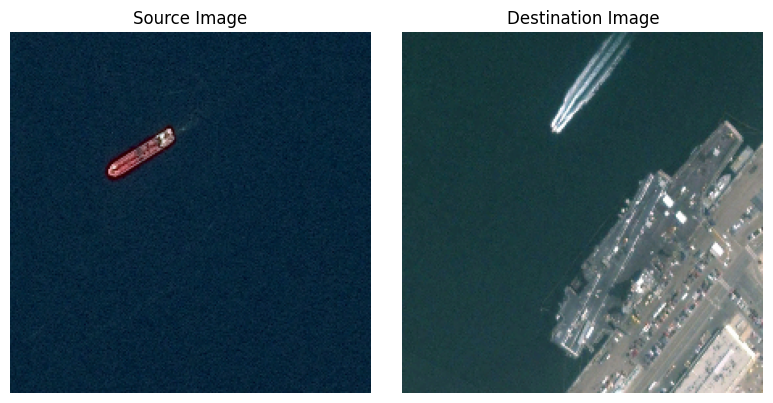

In [3]:
# src_path = 'E:/Datasets/HRSC2016/JPEGImages/2000000003.bmp'
# dst_path = 'E:/Datasets/HRSC2016/JPEGImages/100001660.bmp'

src_path = "C:/Users/20202016/Documents/Master/Master Thesis/Datasets/HRSC2016/JPEGImages/100000085.bmp"
dst_path = "C:/Users/20202016/Documents/Master/Master Thesis/Datasets/HRSC2016/JPEGImages/100001660.bmp"


fig, axes = plt.subplots(1, 2, figsize=(8, 4))
src_image = np.array(load_and_preprocess_image(src_path))
dst_image = np.array(load_and_preprocess_image(dst_path))

axes[0].imshow(src_image)
axes[0].set_title('Source Image')
axes[0].axis('off')

axes[1].imshow(dst_image)
axes[1].set_title('Destination Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Seamless Cloning Process

OpenCV's seamless cloning operates in the following steps:
1. Load source and destination images
2. Create a binary mask for the source image
3. Specify the location for blending
4. Apply seamless cloning using one of two modes:
   - NORMAL_CLONE: Preserves gradients from source image
   - MIXED_CLONE: Combines gradients from both images

The quality of results depends on:
- Mask accuracy
- Position of blending
- Color compatibility between images
- Image resolution and sizes

In [4]:
def seamless_clone(src_path, dst_path, mask, mode="normal"):
    # Load images
    src = load_and_preprocess_image(src_path)
    dst = load_and_preprocess_image(dst_path)

    # Validate image sizes
    if src.shape[:2] != mask.shape[:2]:
        raise ValueError("Source image and mask must have same dimensions")

    # Calculate random center position with margins
    margin = 50  # Safe margin from edges
    center = (
        np.random.randint(margin, dst.shape[1] - margin),
        np.random.randint(margin, dst.shape[0] - margin)
    )

    if mode == "mixed":

        # Soften the edges of the mask
        mask = cv2.GaussianBlur(mask, (5,5), 0)

        # Perform mixed seamless cloning
        result = cv2.seamlessClone(
            src, dst, mask, center,
            flags=cv2.MIXED_CLONE,
        )

    else:
        # Soften the edges of the mask
        mask = cv2.GaussianBlur(mask, (5,5), 0)

        # Perform normal seamless cloning
        result = cv2.seamlessClone(
            src, dst, mask, center,
            flags=cv2.NORMAL_CLONE,
        )

    return src, dst, result

In [5]:
def parse_voc_xml(xml_path):
    """
    Parse PASCAL VOC annotation XML file.

    Args:
        xml_path (str): Path to XML annotation file

    Returns:
        tuple: (list of bounding boxes, list of class labels)
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    class_labels = []

    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)

        boxes.append([xmin, ymin, xmax, ymax])
        class_labels.append(name)

    return boxes, class_labels

In [6]:
def create_mask_from_bbox(image_shape, xml_path, original_size, target_size):
    """
    Create a binary mask from bounding boxes found in the XML file,
    adjusting for resized coordinates.

    Args:
        image_shape (tuple): Shape of the mask (height, width).
        xml_path (str): Path to the XML file containing bounding box coordinates.
        original_size (tuple): Original dimensions of the image (width, height).
        target_size (tuple): Target dimensions of the image after resizing (width, height).

    Returns:
        np.ndarray: Binary mask with bounding box areas marked.
    """
    # Initiatize a list of masks
    mask_lst = list()

    # Parse the bounding boxes and class labels from the XML file
    boxes, _ = parse_voc_xml(xml_path)

    # Calculate scaling factors
    scale_x = target_size[0] / original_size[0]
    scale_y = target_size[1] / original_size[1]

    # Loop through each bounding box
    for box in boxes:

        # Initialize the mask with zeros
        mask = np.zeros(image_shape[:2], dtype=np.uint8)

        # Extract coordinates from the bounding box
        xmin, ymin, xmax, ymax = box

        # Scale the coordinates to match the target size
        xmin = int(xmin * scale_x)
        ymin = int(ymin * scale_y)
        xmax = int(xmax * scale_x)
        ymax = int(ymax * scale_y)

        # Fill the corresponding area in the mask with 255 (white)
        mask[ymin:ymax, xmin:xmax] = 255

        # Add to the list of masks
        mask_lst.append(mask)

    return mask_lst

In [7]:
def get_image_dimensions(image_path):
    """
    Get image dimensions efficiently using PIL.

    Args:
        image_path (str): Path to the image file

    Returns:
        tuple: (width, height) of the image
    """
    with Image.open(image_path) as img:
        return img.size  # Returns (width, height)


In [14]:
def object_seamless_clone(src_path, dst_path, mask, center, mode="normal"):
    # Load images
    src = load_and_preprocess_image(src_path)
    dst = load_and_preprocess_image(dst_path)

    # Validate image sizes
    if src.shape[:2] != mask.shape[:2]:
        raise ValueError("Source image and mask must have same dimensions")

    if mode == "mixed":

        # Soften the edges of the mask
        mask = cv2.GaussianBlur(mask, (5,5), 0)

        # Perform mixed seamless cloning
        result = cv2.seamlessClone(
            src, dst, mask, center,
            flags=cv2.MIXED_CLONE,
        )

    else:
        # Soften the edges of the mask
        mask = cv2.GaussianBlur(mask, (5,5), 0)

        # Perform normal seamless cloning
        result = cv2.seamlessClone(
            src, dst, mask, center,
            flags=cv2.NORMAL_CLONE,
        )

    return src, dst, result

## Visualize: BBox-based Mask

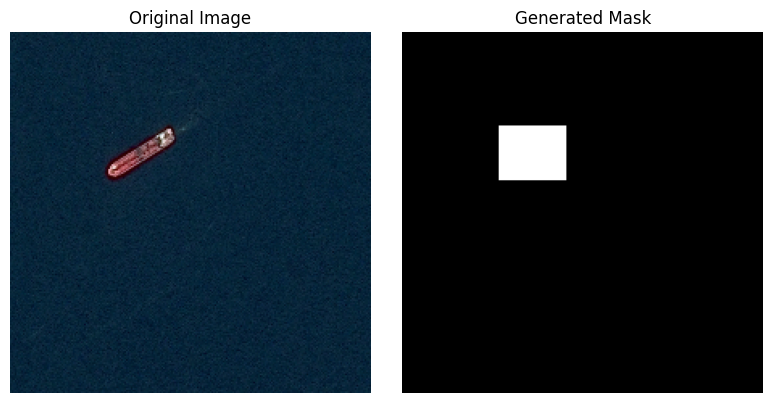

In [8]:
xml_path = "C:/Users/20202016/Documents/Master/Master Thesis/Datasets/HRSC2016/Annotations/100000085.xml"
image_shape = src_image.shape

# Generate binary mask from XML
masks = create_mask_from_bbox(image_shape, xml_path, original_size = get_image_dimensions(src_path), target_size = (224, 224))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Display the original image
ax1.imshow(src_image)
ax1.set_title('Original Image')
ax1.axis('off')

# Display the mask
ax2.imshow(masks[0], cmap='gray')
ax2.set_title('Generated Mask')
ax2.axis('off')

plt.tight_layout()
plt.show()


## Visualize: Seamless Clones

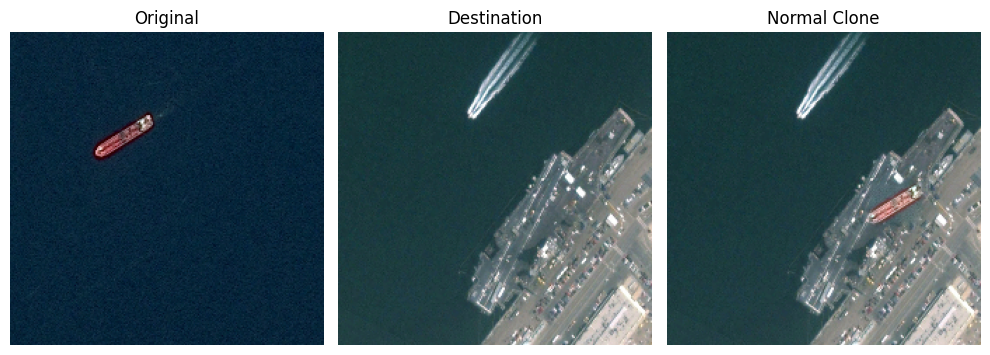

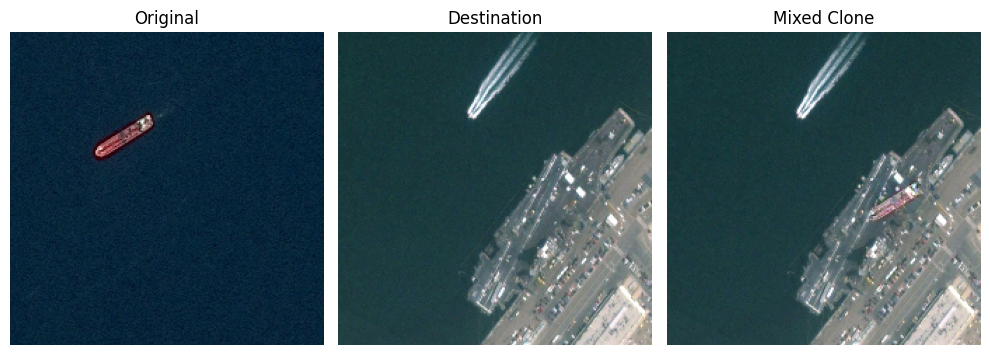

In [9]:
# Normal clone
normal_results = seamless_clone(
    src_path, dst_path, masks[0],
    mode="normal"
)

display_images(
    normal_results,
    ["Original", "Destination", "Normal Clone"],
    figsize=(10,5)
)

# Mixed clone
mixed_results = seamless_clone(
    src_path, dst_path, masks[0],
    mode="mixed"
)

display_images(
    mixed_results,
    ["Original", "Destination", "Mixed Clone"],
    figsize=(10,5)
)

## Optimizing Insertion


## Optimal Insertion Location

Inserting the object in the right location enhances the realism of the image. There are a few approaches that seem promising:

- Object-based insertion: Insert object close to another object assuming that the object in rather standalone.
- Segment-based insertion: Insert the object in the water segment, assuming the object to insert is a boat.
- Model-based insertion: Use existing models to determine the optimal location to insert.

In [10]:
xml_src = "C:/Users/20202016/Documents/Master/Master Thesis/Datasets/HRSC2016/Annotations/100000085.xml"
xml_dst = "C:/Users/20202016/Documents/Master/Master Thesis/Datasets/HRSC2016/Annotations/100001660.xml"

# Obtain bounding boxes
src_boxes, _ = parse_voc_xml(xml_src)
dst_boxes, _ = parse_voc_xml(xml_dst)

In [11]:
def object_insertion(src_bbox,
             dst_bbox,
             original_size,
             margin = 20,
             target_size=(224, 224)):
    """
    Generates a new bounding box that is close to but does not overlap with the given bounding box.
    The new bounding box may have a different size.

    Args:
        src_bbox (list): [x_min, y_min, x_max, y_max] representing the original bounding box.
        min_distance (int): Minimum distance to move the new bounding box away.
        max_distance (int): Maximum distance to move the new bounding box away.
        size_variation (float): Maximum percentage by which the new box size can vary (e.g., 0.5 = ±50%).

    Returns:
        list: [x_min, y_min, x_max, y_max] for the new non-overlapping bounding box.
    """

    # # Initialize minimum and maximum distance to move the new bounding box
    min_distance = 0.1 * target_size[0]
    max_distance = 0.5 * target_size[0]

    # Calculate scaling factors
    scale_x = target_size[0] / original_size[0]
    scale_y = target_size[1] / original_size[1]

    for bbox in [src_bbox, dst_bbox]:
        # Extract the coordinates of the original bounding box
        x_min, y_min, x_max, y_max = src_bbox

        # Convert values to integer
        x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)

        if bbox == src_bbox:
            # Compute the center of the original bounding box
            center_x = (x_min + x_max) / 2
            center_y = (y_min + y_max) / 2

            # Extract the original bounding box size
            orig_width = x_max - x_min
            orig_height = y_max - y_min

        else:
            # Extract the destination bounding box size
            new_width = x_max - x_min
            new_height = y_max - y_min

    for i in range(100):
        # Compute diagonal distances (to ensure proper separation)
        orig_diag = np.sqrt(orig_width**2 + orig_height**2) / 2
        new_diag = np.sqrt(new_width**2 + new_height**2) / 2

        # Choose a random angle (0 to 360 degrees)
        angle = random.uniform(0, 2 * np.pi)

        # Ensure the distance is at least greater than the diagonal
        min_safe_distance = orig_diag + min_distance
        max_safe_distance = orig_diag + max_distance
        distance = random.uniform(min_safe_distance, max_safe_distance)
        #print(min_safe_distance, max_safe_distance, distance)

        # Compute new center position using polar coordinates
        new_center_x = (center_x + distance * np.cos(angle)) * scale_x
        new_center_y = (center_y + distance * np.sin(angle)) * scale_y
        #print(new_center_x, new_center_y)

        # Compute new bounding box coordinates
        new_x_min = int(new_center_x - new_width / 2)
        new_y_min = int(new_center_y - new_height / 2)
        new_x_max = int(new_center_x + new_width / 2)
        new_y_max = int(new_center_y + new_height / 2)

        new_bbox = [new_x_min, new_y_min, new_x_max, new_y_max]

        if min(new_bbox) > margin & max(new_bbox) < (target_size[0] - margin):
            final_bbox = new_bbox
            return final_bbox

        else:
            continue

new_bbox = object_insertion(src_boxes[0], dst_boxes[0], get_image_dimensions(src_path))
print(new_bbox)

[12, 6, 226, 126]


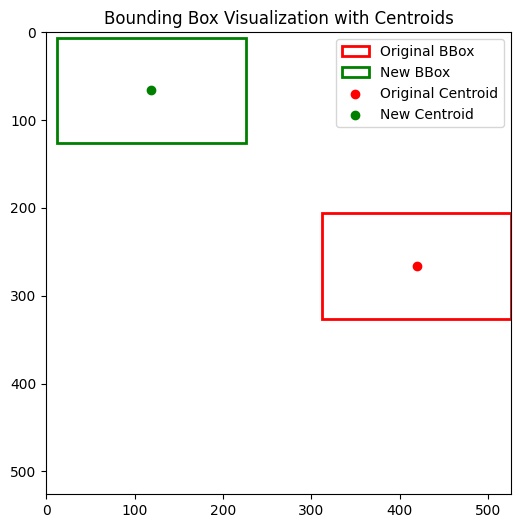

In [12]:
def visualize_bboxes(original_bbox, new_bbox):
    """
    Visualizes the original and new bounding boxes with centroids on a blank plot.

    Args:
        original_bbox (list): [x_min, y_min, x_max, y_max] for the original bounding box.
        new_bbox (list): [x_min, y_min, x_max, y_max] for the new bounding box.
        image_size (tuple): Size of the plot (height, width).
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    max_size = max(np.unique([original_bbox + new_bbox]))
    ax.set_xlim(0, max_size)
    ax.set_ylim(0, max_size)

    # Invert Y-axis to match image coordinate system
    ax.invert_yaxis()

    # Extract coordinates
    ox_min, oy_min, ox_max, oy_max = original_bbox
    nx_min, ny_min, nx_max, ny_max = new_bbox

    # Compute centroids
    original_centroid = ((ox_min + ox_max) / 2, (oy_min + oy_max) / 2)
    new_centroid = ((nx_min + nx_max) / 2, (ny_min + ny_max) / 2)

    # Draw bounding boxes
    ax.add_patch(plt.Rectangle((ox_min, oy_min), ox_max - ox_min, oy_max - oy_min,
                               edgecolor='red', linewidth=2, fill=False, label="Original BBox"))
    ax.add_patch(plt.Rectangle((nx_min, ny_min), nx_max - nx_min, ny_max - ny_min,
                               edgecolor='green', linewidth=2, fill=False, label="New BBox"))

    # Plot centroids
    ax.scatter(*original_centroid, color='red', marker='o', label="Original Centroid")
    ax.scatter(*new_centroid, color='green', marker='o', label="New Centroid")

    # Titles and legend
    ax.set_title("Bounding Box Visualization with Centroids")
    ax.legend()
    plt.show()

# Visualize
visualize_bboxes(src_boxes[0], new_bbox)

In [13]:
def get_center(bbox):
    """
    Compute the center of a bounding box.

    Args:
        bbox (list): Bounding box as [x_min, y_min, x_max, y_max]

    Returns:
        tuple: (center_x, center_y) coordinates of the bounding box center
    """
    x_min, y_min, x_max, y_max = bbox
    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    return int(center_x), int(center_y)

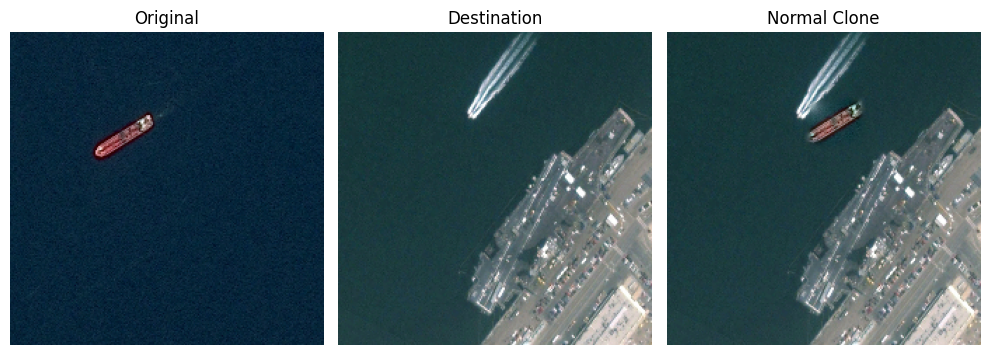

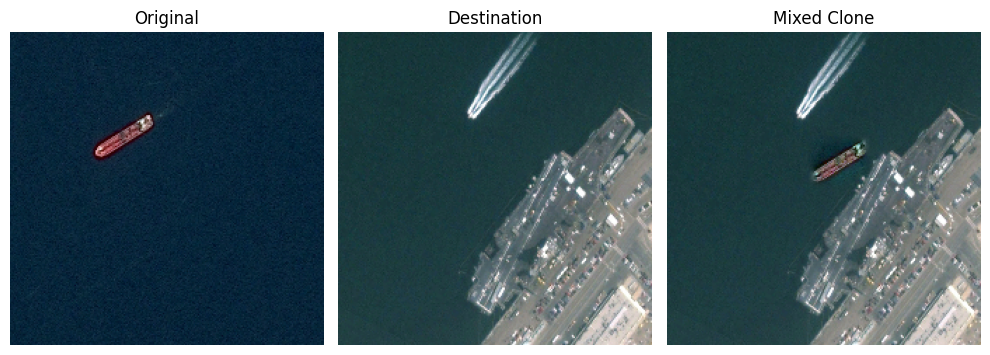

In [15]:
# Normal clone
normal_results = object_seamless_clone(
    src_path, dst_path, masks[0],
    center = get_center(object_insertion(src_boxes[0], dst_boxes[0], get_image_dimensions(src_path))),
    mode="normal"
)

display_images(
    normal_results,
    ["Original", "Destination", "Normal Clone"],
    figsize=(10,5)
)

# Mixed clone
mixed_results = object_seamless_clone(
    src_path, dst_path, masks[0],
    center = get_center(object_insertion(src_boxes[0], dst_boxes[0], get_image_dimensions(src_path))),
    mode="mixed"
)

display_images(
    mixed_results,
    ["Original", "Destination", "Mixed Clone"],
    figsize=(10,5)
)